# Analisis de datos 

__En la primer casilla se vuelcan los datos y se hacen los import necesarios__

__Es necesario ejecutarla para poder hacer el resto__




In [1]:
import os
import pandas as pd
import datetime
import random
from matplotlib import pyplot as plt
%matplotlib inline

registro = os.path.join(os.getcwd(), "data", "registro_ejemplo.csv")

data_set = pd.read_csv(registro, encoding="utf-8")

data_set

,timestamp,id,evento,usuarie,estado,texto ingresado,respuesta,nivel
0,1.654493e+09,33ff0802-e53f-11ec-8fea-0242ac120002,inicio_partida,sofi,-,-,-,normal
1,1.654633e+09,bd7f4ee8-e53f-11ec-8fea-0242ac120002,intento,sofi,error,Cristiano Ronaldo,Lionel Messi,normal
2,1.654633e+09,6c1bae73-a8d8-4ded-97db-636d59af0ee2,intento,sofi,ok,Lionel Messi,Lionel Messi,normal
3,1.654732e+09,03aea3f6-890c-4194-9613-9c76981083ec,intento,sofi,error,Kylian Mbappé,Alisson,normal
4,1.654742e+09,a1d62ee7-4f35-48a9-9b3e-4fa2f04a6645,intento,sofi,timeout,-,Alisson,normal
5,1.654483e+09,5fb49e99-53a9-48b1-b103-ecbeae12f581,fin,sofi,finalizada,-,-,normal
6,1.654483e+09,5fb49e99-53a9-48b1-b103-ecbeae12f581,fin,sofi,abandonada,-,-,dificil
7,1.654483e+09,5fb49e99-53a9-48b1-b103-ecbeae12f581,fin,leo,error,-,-,facil
8,1.654493e+09,33ff0802-e53f-11ec-8fea-0242ac120002,inicio_partida,sofi,-,-,-,normal
9,1.654493e+09,33ff0802-e53f-11ec-8fea-0242ac120002,inicio_partida,sofi,-,-,-,normal


## 1) Top 10 primeras palabras que se encuentran en las partidas:

# no se me ocurrio una mejor manera, se escuchan sugerencias.

# falta contarlas, pero tambien faltan los datos.

1. Saca todos los datos que no importan.
<br><br>
2. Itera para sacar el 1er "ok" de cada partida.
<br><br>
3. Usamos el evento "inicio_partida" para separarlas.

In [6]:
data_frame = data_set.drop(["timestamp", "id", "usuarie", "texto ingresado", "nivel"], axis="columns")
data_frame = data_frame.drop(data_frame[data_frame.estado == "error"].index)
data_frame = data_frame.drop(data_frame[data_frame.estado == "timeout"].index)

nueva = True
lista_palabras = []

for row in data_frame.itertuples():
    evento = getattr(row, "evento")
    estado = getattr(row, "estado")
    if evento == "inicio_partida":
        nueva = True
    if nueva and estado == "ok":
        lista_palabras.append(getattr(row, "respuesta"))
        nueva = False

df_new = pd.DataFrame(lista_palabras, columns=["Palabras"])
df_new.groupby("Palabras").size()

#
#
# Testear bien cuando tengamos un registro posta, porque me parece que no termina de funcionar como debe
#
#

Palabras
Lionel Messi    1
dtype: int64

## 2) Grafico de partidas finalizadas por estado:

__pido perdon por ese for__


# acordate de modificar esto en el futuro cercano

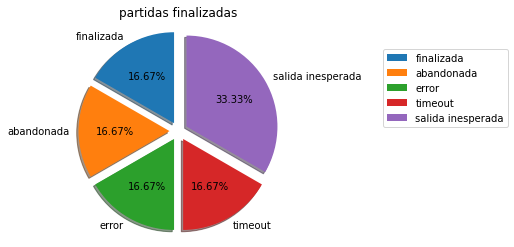

In [5]:
df = data_set.loc[:, ["evento", "estado"]]
df = df.drop(df[df.evento == "intento"].index)


cant_incontable = 0

nueva = False
for row in df.itertuples():
    evento = getattr(row, "evento")
    if nueva and evento == "inicio_partida":
        cant_incontable += 1
    elif evento == "inicio_partida":
        nueva = True
    elif evento == "fin":
        nueva = False
if nueva:
    cant_incontable += 1

df = df[df["evento"] == "fin"]
df = df.groupby(["estado"]).size()

cant_fin = df["finalizada"]
cant_abandonada = df["abandonada"]
cant_error = df["error"]
cant_time = df["timeout"]

etiquetas = ["finalizada", "abandonada", "error", "timeout", "salida inesperada"]

datos_dibujo = [cant_fin, cant_abandonada, cant_error, cant_time, cant_incontable]

explode = (0.1, 0.1, 0.1,  0.1, 0.1)

plt.pie(datos_dibujo, explode=explode, labels=etiquetas, autopct='%1.2f%%',
shadow=True, startangle=90, labeldistance= 1.1)

plt.axis('equal')
plt.legend(etiquetas, loc=1, bbox_to_anchor=(1.5, 0.9))
plt.title("partidas finalizadas")
plt.show()

#
#
# faltan demasiadas cosas
#
#

## 3) Grafico de partidas finalizadas segun genero:

# acordate de meter un metodo en perfiles para no romper encapsulamiento

1. pido los datos de los usuarios, para poder hacer la conexion nombre/genero.
<br><br> 
2. separo todos los eventos de fin.
<br><br>
3. enmascaro los datos para cambiar nombre por el genero autopercibido.
<br><br>
4. paso los datos a la figurita.

/tmp/ipykernel_7011/926637676.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "usuarie"] = df.loc[:, "usuarie"].apply(lambda x: usuarios[x][1] if x in usuarios.keys() else "indeterminado")


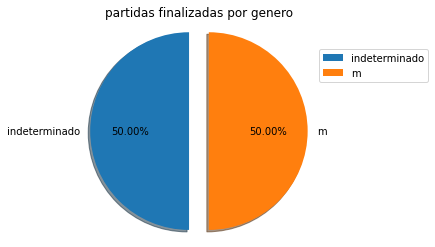

In [116]:
from json import load as jload

jugadores = os.path.join(os.getcwd(), "data", "jugadores.json")

try:
    with open(jugadores, "r", encoding="utf-8") as entrada:
        usuarios = jload(entrada)
except FileNotFoundError:
    usuarios = []

    
df = data_set[data_set["evento"] == "fin"]

# esto tira cartelito rojo
df.loc[:, "usuarie"] = df.loc[:, "usuarie"].apply(lambda x: usuarios[x][1] if x in usuarios.keys() else "indeterminado")
# pero funciona

nuevo = df.groupby(["usuarie"]).size()

etiquetas = nuevo.index.unique()
etiquetas = list(etiquetas)

datos_dibujo = []
for key in etiquetas:
    datos_dibujo.append(nuevo[key])

explode = tuple([(0.1) for x in datos_dibujo])

plt.pie(datos_dibujo, explode=explode, labels=etiquetas, autopct='%1.2f%%',
shadow=True, startangle=90, labeldistance= 1.1)

plt.axis('equal')
plt.legend(etiquetas, loc=1, bbox_to_anchor=(1.2, 0.9))
plt.title("partidas finalizadas por genero")
plt.show()

#
# imposible saber si esto funciona con el registro completo
#

## 4) Grafico de las partidas finalizadas segun nivel:

1. separo las partidas que finalizaron.
<br><br>
2. las agrupo por nivel y mando al grafico.

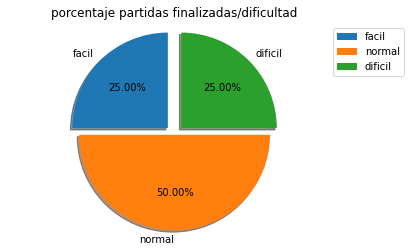

In [36]:
df = data_set[data_set["evento"] == "fin"]
df = df.groupby(["nivel"]).size()

etiquetas = ["facil", "normal", "dificil"]

cant_facil = df["facil"]
cant_normal = df["normal"]
cant_dificil = df["dificil"]

datos_dibujo = [cant_facil, cant_normal, cant_dificil]

explode = (0.1, 0, 0.1)

plt.pie(datos_dibujo, explode=explode, labels=etiquetas, autopct='%1.2f%%',
shadow=True, startangle=90, labeldistance= 1.1)

plt.axis('equal')
plt.legend(etiquetas, loc=1, bbox_to_anchor=(1.2, 1.0))
plt.title("porcentaje partidas finalizadas/dificultad")
plt.show()

#
#
# faltan demasiadas cosas
#
#

## 5) Duracion total de la partida:

# no se como se calcula en el registro

# pide duracion total de todas las partidas

# en un grafico de puntitos (tipo garfico de toda la vida)

# hay que testear una vez que completemos el registro

In [39]:
def sacar_tiempo(inicio, fin):
    if inicio > fin:
        respuesta = pd.Timedelta(fin - inicio).total_seconds()
    else:
        respuesta = pd.Timedelta(inicio - fin).total_seconds()
    
    if respuesta > 0:
        return (str(datetime.timedelta(seconds=respuesta)))
    else:
        return (str(datetime.timedelta(seconds=respuesta)))[8:]

df = data_set.drop(data_set[data_set.evento == "intento"].index)
df.timestamp = df.timestamp.apply(lambda x: pd.Timestamp(x, unit='s'))

tempo = 0
partida = True
lista = []

for index, row in df.iterrows():
    if row["evento"] == "inicio_partida":
        tempo = row["timestamp"]
        partida = True
    elif row["evento"] == "fin" and partida:
        lista.append(sacar_tiempo(tempo,row["timestamp"]))
        partida = False
        
lista = map(lambda x: pd.Timedelta(x), lista)
maximo = max(lista)
h = maximo.components[1]
m = maximo.components[2]
s = maximo.components[3]
print(f"La partida mas larga duró: {h} horas, {m} minutos y {s} segundos")


La partida mas larga duró: 21 horas, 11 minutos y 53 segundos


## 6) tiempo de la respuesta correcta mas rapida:

# Faltan datos para chequear que anda

# revisar

In [96]:
data_frame = data_set.drop(["id", "usuarie", "texto ingresado", "nivel"], axis="columns")
df = data_frame.drop(data_frame[data_frame.evento == "fin"].index)
df.timestamp = df.timestamp.apply(lambda x: pd.Timestamp(x, unit='s'))

anterior = 0
lista_tiempos = []

for index, row in data_frame.iterrows():
    if anterior and row["estado"] == "ok":
        lista_tiempos.append(pd.Timedelta(row["timestamp"] - anterior).total_seconds()) 
    anterior = row["timestamp"]
    
lista_tiempos

#min(lista)
#faltan datos reales para chequear que funciona

[0.0]

## 7) Promedio de tiempo de respuesta para respuestas correctas:

# la vida...

# Siguen faltando datos 

In [40]:
data_frame = data_set.drop(["id", "usuarie", "texto ingresado", "nivel"], axis="columns")
df = data_frame.drop(data_frame[data_frame.evento == "fin"].index)
df.timestamp = df.timestamp.apply(lambda x: pd.Timestamp(x, unit='s'))

anterior = 0
lista_tiempos = []

for index, row in data_frame.iterrows():
    if anterior and row["estado"] == "ok":
        lista_tiempos.append(pd.Timedelta(row["timestamp"] - anterior).total_seconds()) 
    anterior = row["timestamp"]
    
lista_tiempos

#igual que el anterior, pero sumas todo y dividis por len(lista)
# ...
# creo

[0.0]

## 8) Promedio de tiempo de partida general:

# separador

In [ ]:
#igual que el de 2 veces arriba, no entiendo la diferencia conceptual de cada uno
# preguntar en la consulta

## 9) Porcentaje de acierto por usuarie:

# necesitaria ampliar el registro_ejemplo para esto

# 

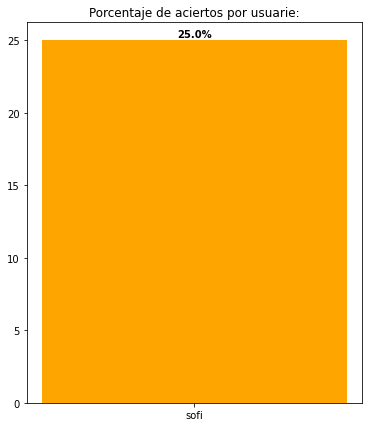

In [149]:
df = data_set.drop(data_set[data_set.evento != "intento"].index)
usuarios = data_set["usuarie"].unique()
nuevo = df.groupby(["usuarie", "estado"]).size()

result = {}

for nombre in usuarios:
    if nombre in nuevo and "ok" in nuevo[nombre].keys():
        aux = (nuevo[nombre].ok / nuevo[nombre].sum()) * 100
        result[nombre] = (round((aux), 2))
        
colores = [
            "Red", "Orange", "Purple", "Pink",
            "Yellow", "Blue", "Green", "bisque",
            "aqua", "magenta", "peru", "firebrick",
            "sienna", "gold", "deeppink"
          ]
plt.figure(figsize=(6,7))
lista_colores = [random.choice(colores) for i in result.keys()]                  
graph = plt.bar(result.keys(), result.values(), color = lista_colores)
plt.title("Porcentaje de aciertos por usuarie:")

i = 0
for p in graph:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x+width/2,
             y+height*1.01,
             str(list(result.values())[i]) +'%',
             ha='center',
             weight='bold')
    i += 1

plt.show()

#
# revisar con registro mas amplio
#

## 10) Cantidad de tarjetas para las que el usuarie no dió respuesta (timeout):

# Taria bueno un registro

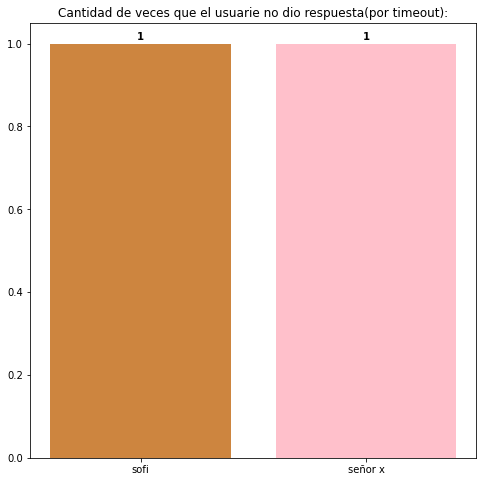

In [155]:
df = data_set.drop(data_set[data_set.evento != "intento"].index)
usuarios = data_set["usuarie"].unique()
df = df.drop(df[df.estado != "timeout"].index)
nuevo = df.groupby(["usuarie", "estado"]).size()

result = {}

for nombre in usuarios:
    if nombre in nuevo:
        result[nombre] = nuevo[nombre].timeout
        
colores = [
            "Red", "Orange", "Purple", "Pink",
            "Yellow", "Blue", "Green", "bisque",
            "aqua", "magenta", "peru", "firebrick",
            "sienna", "gold", "deeppink"
          ]

plt.figure(figsize=(8,8))
lista_colores = [random.choice(colores) for i in result.keys()]                      
graph = plt.bar(result.keys(), result.values(), color = lista_colores)
plt.title("Cantidad de veces que el usuarie no dio respuesta(por timeout):")

i = 0
for p in graph:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x+width/2,
             y+height*1.01,
             str(list(result.values())[i]),
             ha='center',
             weight='bold')
    i += 1

plt.show()

        
#necesitamos registros mas completos

## 11) Cantidad de tarjetas en las que el usuarie dió una respuesta errónea:

# lo mismo que el anterior

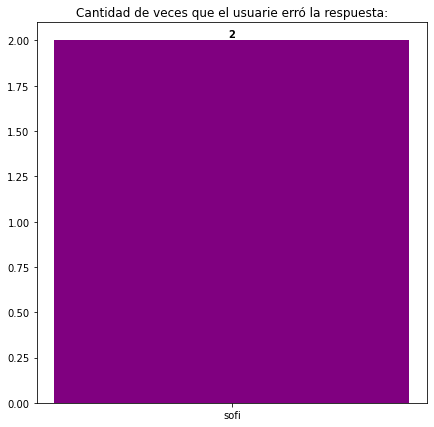

In [160]:
df = data_set.drop(data_set[data_set.evento != "intento"].index)
usuarios = data_set["usuarie"].unique()
df = df.drop(df[df.estado != "error"].index)
nuevo = df.groupby(["usuarie", "estado"]).size()

result = {}

for nombre in usuarios:
    if nombre in nuevo:
        result[nombre] = nuevo[nombre].error


        
colores = [
            "Red", "Orange", "Purple", "Pink",
            "Yellow", "Blue", "Green", "bisque",
            "aqua", "magenta", "peru", "firebrick",
            "sienna", "gold", "deeppink"
          ]

plt.figure(figsize=(7,7))
lista_colores = [random.choice(colores) for i in result.keys()]                      
graph = plt.bar(result.keys(), result.values(), color = lista_colores)
plt.title("Cantidad de veces que el usuarie erró la respuesta:")

i = 0
for p in graph:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x+width/2,
             y+height*1.01,
             str(list(result.values())[i]),
             ha='center',
             weight='bold')
    i += 1

plt.show()



opcional_1) Gráfico que muestre el porcentaje de partidas que se juegan para cada día de la
semana.

__no lo hago ni en pedo__

## opcional_2) Promedio de tiempo de partidas finalizadas por nivel.

# preguntar como se mide el tiempo

## opcional_3) Porcentaje de palabras encontradas en las partidas “timeout, es decir que finalizaron por falta de tiempo para completar.

# mas facil que el primer opcional, parece